# Import Libraries

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import h5py

# Import Dataset

In [35]:
DATASET_FOLDER = 'dataset/nusaX'

train_df = pd.read_csv(f'{DATASET_FOLDER}/train.csv')
valid_df = pd.read_csv(f'{DATASET_FOLDER}/valid.csv')
test_df = pd.read_csv(f'{DATASET_FOLDER}/test.csv')

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
valid_df['label'] = label_encoder.transform(valid_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

X_train, y_train = train_df['text'].values, train_df['label'].values
X_valid, y_valid = valid_df['text'].values, valid_df['label'].values
X_test, y_test   = test_df['text'].values,  test_df['label'].values

# Vectorization

In [36]:
vocab_size = 10000
sequence_length = 100
num_classes = len(label_encoder.classes_)

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorizer.adapt(X_train)

X_train_vec = vectorizer(X_train)
X_valid_vec = vectorizer(X_valid)
X_test_vec = vectorizer(X_test)

# Build and Train Keras Model

In [37]:
def create_rnn_model(rnn_layers, rnn_cells, rnn_type):
    model = models.Sequential()
    model.add(layers.Input(shape=(sequence_length,)))
    model.add(layers.Embedding(vocab_size, 128))

    for i in range(rnn_layers):
        if rnn_type == 'unidirectional':
            return_sequences = True if i < rnn_layers - 1 else False
            model.add(layers.SimpleRNN(rnn_cells[i], return_sequences=return_sequences))
        elif rnn_type == 'bidirectional':
            return_sequences = True if i < rnn_layers - 1 else False
            model.add(layers.Bidirectional(layers.SimpleRNN(rnn_cells[i], return_sequences=return_sequences)))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [38]:
def train_and_evaluate(model_name, rnn_layers, rnn_cells, rnn_type):
    print(f"\n--- Training Model: {model_name} ---")
    model = create_rnn_model(rnn_layers, rnn_cells, rnn_type)
    history = model.fit(X_train_vec, y_train,
                        epochs=15,
                        validation_data=(X_valid_vec, y_valid),
                        verbose=1)

    model_filename = f'models/model_{model_name}.h5'
    model.save(model_filename)
    print(f"Model saved to {model_filename}")

    y_pred_keras = np.argmax(model.predict(X_test_vec), axis=1)
    f1_keras = f1_score(y_test, y_pred_keras, average='macro')
    print(f"Keras Model Test Macro F1-score: {f1_keras:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, f1_keras, history, model_filename

# Training Variation

## Layer Count


--- Training Model: RNN_Layers_1 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3340 - loss: 1.1198 - val_accuracy: 0.2700 - val_loss: 1.1239
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4544 - loss: 1.0843 - val_accuracy: 0.4400 - val_loss: 1.0882
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6348 - loss: 0.8703 - val_accuracy: 0.4600 - val_loss: 1.1264
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6497 - loss: 0.8421 - val_accuracy: 0.4100 - val_loss: 1.1961
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7678 - loss: 0.6364 - val_accuracy: 0.4300 - val_loss: 1.1861
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7591 - loss: 0.5627 - val_accuracy: 0.3600 - val_loss: 1.3616
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8488 - loss: 0.4237 - val_accuracy: 0.4100 - val_loss: 1.3824
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9317 - l

Model saved to models/model_RNN_Layers_1.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Keras Model Test Macro F1-score: 0.3749


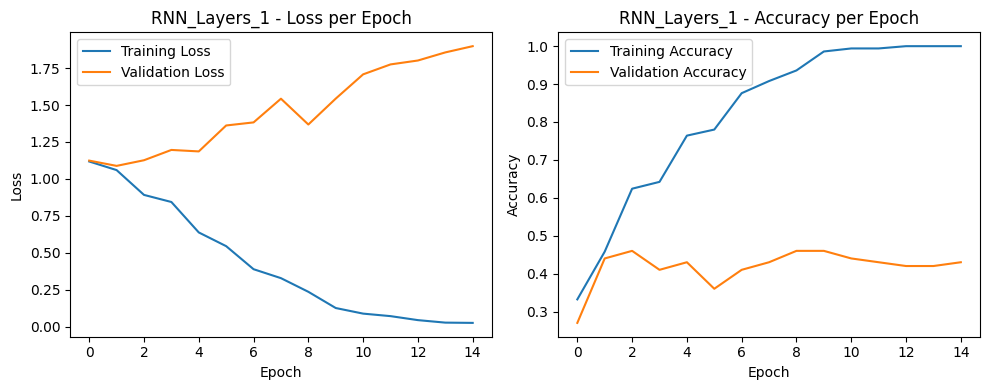


--- Training Model: RNN_Layers_2 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3382 - loss: 1.2336 - val_accuracy: 0.3900 - val_loss: 1.0824
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4616 - loss: 1.0724 - val_accuracy: 0.3800 - val_loss: 1.2332
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6764 - loss: 0.7447 - val_accuracy: 0.4800 - val_loss: 1.2126
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8413 - loss: 0.4763 - val_accuracy: 0.4300 - val_loss: 1.2225
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9729 - loss: 0.1843 - val_accuracy: 0.4200 - val_loss: 1.6171
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9966 - loss: 0.0654 - val_accuracy: 0.4300 - val_loss: 1.5245
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9979 - loss: 0.0517 - val_accuracy: 0.4500 - val_loss: 1.8576
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - l

Model saved to models/model_RNN_Layers_2.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Keras Model Test Macro F1-score: 0.3942


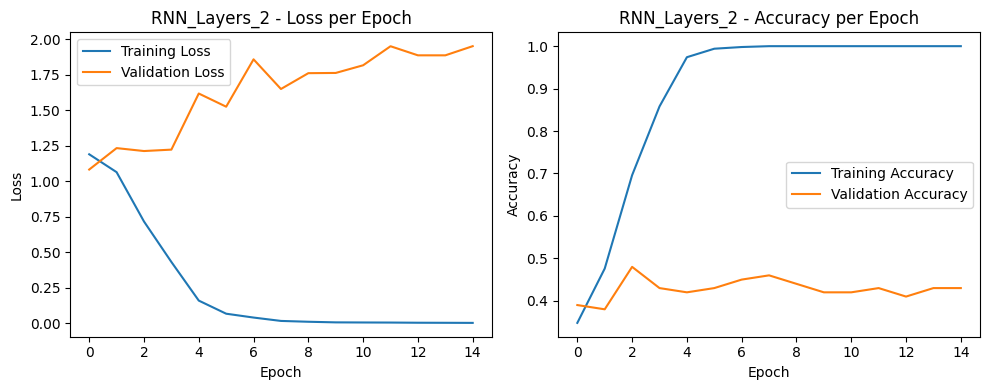


--- Training Model: RNN_Layers_3 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3725 - loss: 1.2792 - val_accuracy: 0.4000 - val_loss: 1.0789
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3600 - loss: 1.2397 - val_accuracy: 0.3900 - val_loss: 1.1767
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4113 - loss: 1.1627 - val_accuracy: 0.4500 - val_loss: 1.1068
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6193 - loss: 0.9181 - val_accuracy: 0.4500 - val_loss: 1.2390
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7302 - loss: 0.7043 - val_accuracy: 0.4000 - val_loss: 1.3660
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7454 - loss: 0.6099 - val_accuracy: 0.4900 - val_loss: 1.3736
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7194 - loss: 0.6391 - val_accuracy: 0.5500 - val_loss: 1.0846
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8100 - l

Model saved to models/model_RNN_Layers_3.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Keras Model Test Macro F1-score: 0.5022


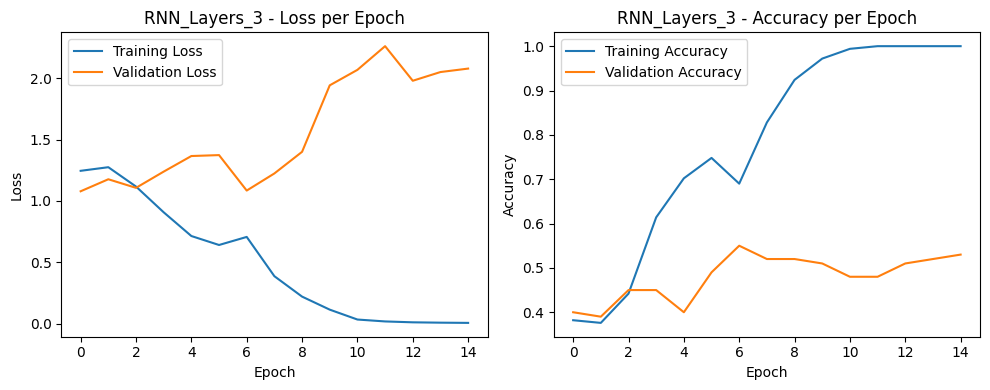


Comparison of F1-scores for different RNN layer counts:
  1 RNN Layers: Macro F1-score = 0.3749
  2 RNN Layers: Macro F1-score = 0.3942
  3 RNN Layers: Macro F1-score = 0.5022


In [39]:
layer_variations = [1, 2, 3]
keras_models_layer_count = {}
f1_scores_layer_count = {}
histories_layer_count = {}
model_filenames_layer_count = {}

for num_layers in layer_variations:
    model_name = f'RNN_Layers_{num_layers}'
    model, f1, history, model_filename = train_and_evaluate(model_name, num_layers, [64] * num_layers, 'unidirectional')
    keras_models_layer_count[num_layers] = model
    f1_scores_layer_count[num_layers] = f1
    histories_layer_count[num_layers] = history
    model_filenames_layer_count[num_layers] = model_filename

print("\nComparison of F1-scores for different RNN layer counts:")
for num_layers, f1 in f1_scores_layer_count.items():
    print(f"  {num_layers} RNN Layers: Macro F1-score = {f1:.4f}")

## Cells Per Layer


--- Training Model: RNN_Cells_32 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3625 - loss: 1.1355 - val_accuracy: 0.4000 - val_loss: 1.0764
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4734 - loss: 1.0292 - val_accuracy: 0.3700 - val_loss: 1.1412
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7017 - loss: 0.8311 - val_accuracy: 0.3400 - val_loss: 1.1322
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8263 - loss: 0.6657 - val_accuracy: 0.3500 - val_loss: 1.1594
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9015 - loss: 0.4716 - val_accuracy: 0.4100 - val_loss: 1.1984
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9645 - loss: 0.3125 - val_accuracy: 0.3600 - val_loss: 1.3161
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9745 - loss: 0.2429 - val_accuracy: 0.3000 - val_loss: 1.4305
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9943 - l

Model saved to models/model_RNN_Cells_32.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Keras Model Test Macro F1-score: 0.4094


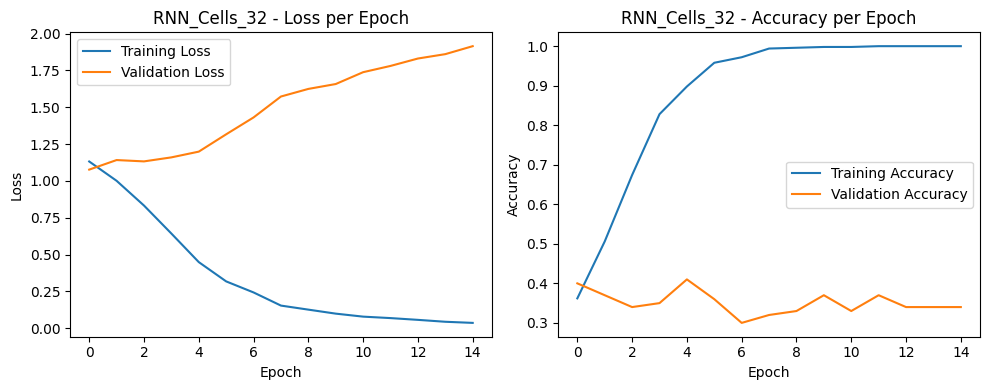


--- Training Model: RNN_Cells_64 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3667 - loss: 1.1262 - val_accuracy: 0.3800 - val_loss: 1.0848
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4451 - loss: 1.0288 - val_accuracy: 0.4000 - val_loss: 1.1242
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5579 - loss: 0.9641 - val_accuracy: 0.3600 - val_loss: 1.1525
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7843 - loss: 0.6147 - val_accuracy: 0.4100 - val_loss: 1.3162
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8670 - loss: 0.4551 - val_accuracy: 0.3800 - val_loss: 1.5042
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9587 - loss: 0.2425 - val_accuracy: 0.3500 - val_loss: 1.5356
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9711 - loss: 0.1619 - val_accuracy: 0.3800 - val_loss: 1.8877
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9592 - l

Model saved to models/model_RNN_Cells_64.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Keras Model Test Macro F1-score: 0.4192


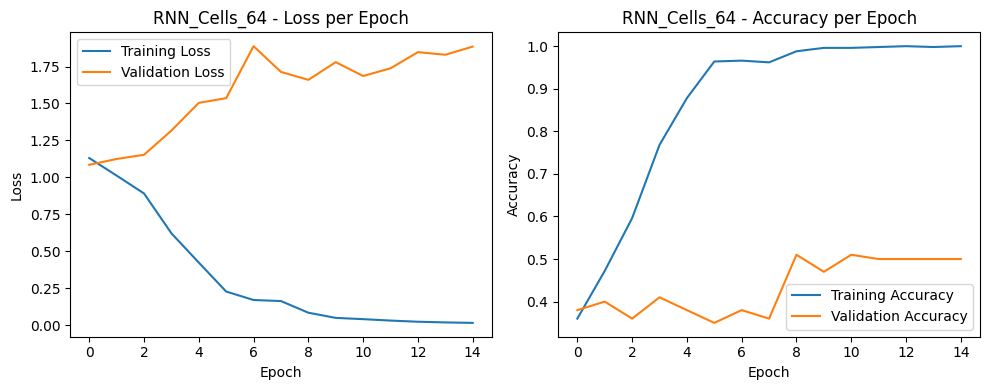


--- Training Model: RNN_Cells_128 ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3569 - loss: 1.1042 - val_accuracy: 0.4000 - val_loss: 1.0700
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4632 - loss: 1.0242 - val_accuracy: 0.3700 - val_loss: 1.1838
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4581 - loss: 1.1060 - val_accuracy: 0.3200 - val_loss: 1.1724
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4298 - loss: 1.1048 - val_accuracy: 0.3000 - val_loss: 1.3814
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6104 - loss: 0.9228 - val_accuracy: 0.4200 - val_loss: 1.2860
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6281 - loss: 0.8864 - val_accuracy: 0.4100 - val_loss: 1.2932
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4520 - loss: 1.1192 - val_accuracy: 0.4000 - val_loss: 1.1988
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6439 - 

Model saved to models/model_RNN_Cells_128.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Keras Model Test Macro F1-score: 0.4014


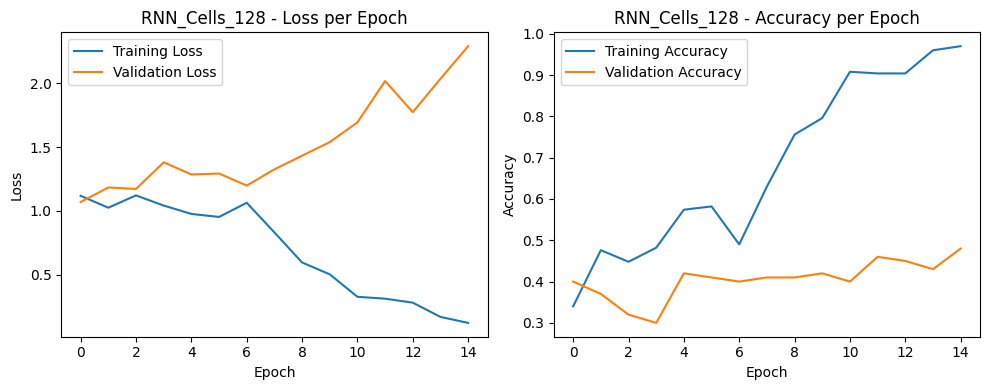


Comparison of F1-scores for different RNN cell counts per layer:
  32 RNN Cells: Macro F1-score = 0.4094
  64 RNN Cells: Macro F1-score = 0.4192
  128 RNN Cells: Macro F1-score = 0.4014


In [40]:
cell_variations = [[32], [64], [128]]
keras_models_cell_count = {}
f1_scores_cell_count = {}
histories_cell_count = {}
model_filenames_cell_count = {}

for cells_per_layer in cell_variations:
    model_name = f'RNN_Cells_{cells_per_layer[0]}'
    model, f1, history, model_filename = train_and_evaluate(model_name, 1, cells_per_layer, 'unidirectional')
    keras_models_cell_count[cells_per_layer[0]] = model
    f1_scores_cell_count[cells_per_layer[0]] = f1
    histories_cell_count[cells_per_layer[0]] = history
    model_filenames_cell_count[cells_per_layer[0]] = model_filename

print("\nComparison of F1-scores for different RNN cell counts per layer:")
for cells, f1 in f1_scores_cell_count.items():
    print(f"  {cells} RNN Cells: Macro F1-score = {f1:.4f}")

## Direction


--- Training Model: RNN_Direction_unidirectional ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3028 - loss: 1.1516 - val_accuracy: 0.4200 - val_loss: 1.0755
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4861 - loss: 1.0356 - val_accuracy: 0.3700 - val_loss: 1.1318
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6858 - loss: 0.7992 - val_accuracy: 0.4700 - val_loss: 1.0798
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8266 - loss: 0.5291 - val_accuracy: 0.4400 - val_loss: 1.1557
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9086 - loss: 0.3866 - val_accuracy: 0.3800 - val_loss: 1.2251
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9409 - loss: 0.2836 - val_accuracy: 0.4100 - val_loss: 1.3819
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9521 - loss: 0.2340 - val_accuracy: 0.4600 - val_loss: 1.2676
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accu

Model saved to models/model_RNN_Direction_unidirectional.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Keras Model Test Macro F1-score: 0.3847


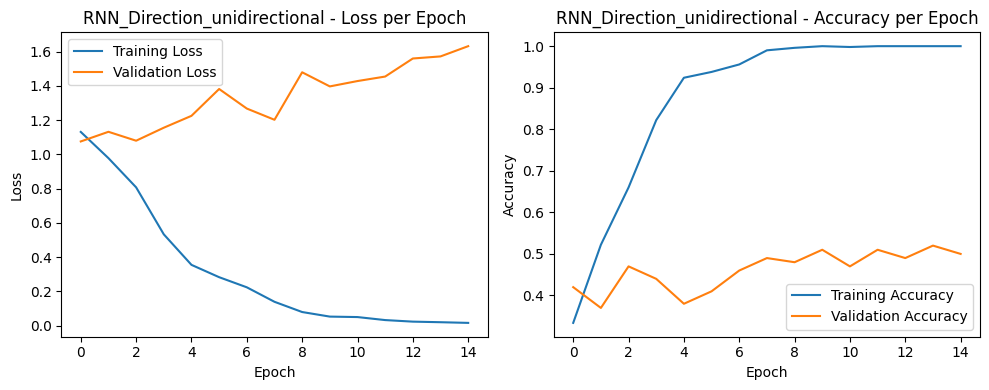


--- Training Model: RNN_Direction_bidirectional ---
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3773 - loss: 1.0954 - val_accuracy: 0.5200 - val_loss: 0.9736
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6636 - loss: 0.8290 - val_accuracy: 0.5000 - val_loss: 1.0033
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8161 - loss: 0.6008 - val_accuracy: 0.5100 - val_loss: 0.9551
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8988 - loss: 0.4101 - val_accuracy: 0.5700 - val_loss: 0.9583
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9714 - loss: 0.1991 - val_accuracy: 0.5800 - val_loss: 0.9868
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9975 - loss: 0.0907 - val_accuracy: 0.6200 - val_loss: 1.0270
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9949 - loss: 0.0458 - val_accuracy: 0.6000 - val_loss: 1.0841
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accur

Model saved to models/model_RNN_Direction_bidirectional.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keras Model Test Macro F1-score: 0.5015


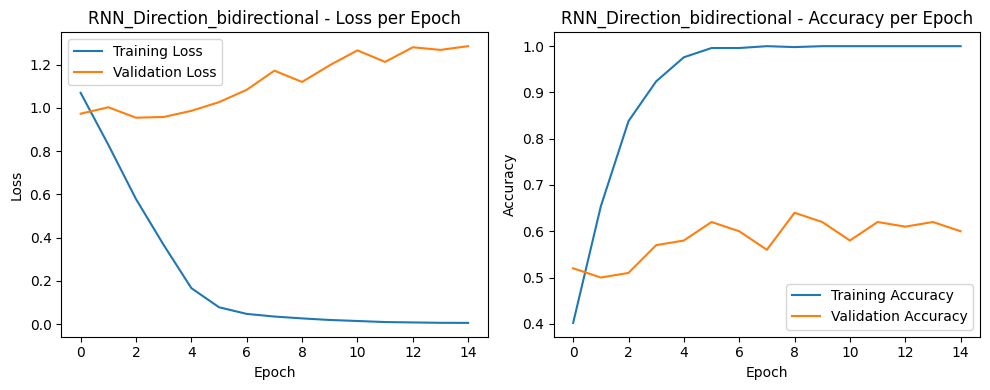

In [41]:
direction_variations = ['unidirectional', 'bidirectional']
keras_models_direction = {}
f1_scores_direction = {}
histories_direction = {}
model_filenames_direction = {}

for rnn_dir in direction_variations:
    model_name = f'RNN_Direction_{rnn_dir}'
    model, f1, history, model_filename = train_and_evaluate(model_name, 1, [64], rnn_dir)
    keras_models_direction[rnn_dir] = model
    f1_scores_direction[rnn_dir] = f1
    histories_direction[rnn_dir] = history
    model_filenames_direction[rnn_dir] = model_filename

# RNN Forward Propagation from Scratch

In [42]:
class EmbeddingLayerScratch:
    def __init__(self, weights):
        self.weights = weights

    def forward(self, inputs):
        return self.weights[inputs]

class SimpleRNNLayerScratch:
    def __init__(self, weights, return_sequences=False):
        self.W = weights[0]
        self.U = weights[1]
        self.b = weights[2]
        self.return_sequences = return_sequences

    def forward(self, inputs):
        if inputs.ndim != 3:
            raise ValueError(f"SimpleRNNLayerScratch expected 3D input, got {inputs.ndim}D with shape {inputs.shape}")

        batch_size, sequence_length, input_dim = inputs.shape
        hidden_dim = self.W.shape[1]
        
        h_t = np.zeros((batch_size, hidden_dim))
        
        all_hidden_states = []

        for t in range(sequence_length):
            x_t = inputs[:, t, :]
            h_t = np.tanh(np.dot(x_t, self.W) + np.dot(h_t, self.U) + self.b)
            if self.return_sequences:
                all_hidden_states.append(h_t)
        
        if self.return_sequences:
            return np.array(all_hidden_states).transpose(1, 0, 2)
        else:
            return h_t

class BidirectionalSimpleRNNLayerScratch:
    def __init__(self, forward_weights, backward_weights, return_sequences=False):
        self.forward_rnn = SimpleRNNLayerScratch(forward_weights, return_sequences=return_sequences)
        self.backward_rnn = SimpleRNNLayerScratch(backward_weights, return_sequences=return_sequences)
        self.return_sequences = return_sequences

    def forward(self, inputs):
        forward_output = self.forward_rnn.forward(inputs)
        
        reversed_inputs = inputs[:, ::-1, :]
        backward_output = self.backward_rnn.forward(reversed_inputs)
        
        if self.return_sequences:
            return np.concatenate([forward_output, backward_output], axis=-1)
        else:
            return np.concatenate([forward_output, backward_output], axis=-1)

class DropoutLayerScratch:
    def __init__(self, rate):
        self.rate = rate
        
    def forward(self, inputs):
        return inputs

class DenseLayerScratch:
    def __init__(self, weights):
        self.W = weights[0]
        self.b = weights[1]

    def forward(self, inputs):
        return np.dot(inputs, self.W) + self.b

class SoftmaxActivationScratch:
    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=-1, keepdims=True))
        return exp_inputs / np.sum(exp_inputs, axis=-1, keepdims=True)

class FromScratchRNNModel:
    def __init__(self, keras_model):
        self.layers = []
        
        for i, layer in enumerate(keras_model.layers):
            layer_keras_weights = layer.get_weights()
            
            if isinstance(layer, layers.Embedding):
                self.layers.append(EmbeddingLayerScratch(layer_keras_weights[0]))
            elif isinstance(layer, layers.SimpleRNN):
                return_sequences_keras = layer.return_sequences
                self.layers.append(SimpleRNNLayerScratch(layer_keras_weights, return_sequences=return_sequences_keras))
            elif isinstance(layer, layers.Bidirectional):
                forward_weights = layer_keras_weights[:3]
                backward_weights = layer_keras_weights[3:]
                return_sequences_keras = layer.forward_layer.return_sequences 
                self.layers.append(BidirectionalSimpleRNNLayerScratch(forward_weights, backward_weights, return_sequences=return_sequences_keras))
            elif isinstance(layer, layers.Dropout):
                self.layers.append(DropoutLayerScratch(layer.rate))
            elif isinstance(layer, layers.Dense):
                self.layers.append(DenseLayerScratch(layer_keras_weights))
            
        self.softmax = SoftmaxActivationScratch()

    def predict(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer.forward(x)
        return self.softmax.forward(x)

In [50]:
def compare_predictions(filename, X_test_vec, y_test):
    print(f"\n--- Comparing Keras and From Scratch for Model: {model_name} ---")

    loaded_keras_model = tf.keras.models.load_model(filename)
    y_pred_loaded_keras_prob = loaded_keras_model.predict(X_test_vec)
    y_pred_loaded_keras = np.argmax(y_pred_loaded_keras_prob, axis=1)
    f1_loaded_keras = f1_score(y_test, y_pred_loaded_keras, average='macro')
    print(f"Keras Loaded Model Test Macro F1-score: {f1_loaded_keras:.4f}")

    scratch_model = FromScratchRNNModel(loaded_keras_model)
    X_test_vec_np = X_test_vec.numpy() 
    y_pred_scratch_prob = scratch_model.predict(X_test_vec_np)
    y_pred_scratch = np.argmax(y_pred_scratch_prob, axis=1)
    f1_scratch = f1_score(y_test, y_pred_scratch, average='macro')
    print(f"From Scratch Test Macro F1-score: {f1_scratch:.4f}")

print("\n--- Running comparison for a selected model ---")

model = 'model_RNN_Direction_unidirectional'
filename = f'models/{model}.h5'
compare_predictions(filename, X_test_vec, y_test)


--- Running comparison for a selected model ---

--- Comparing Keras and From Scratch for Model: RNN_Direction_bidirectional ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Keras Loaded Model Test Macro F1-score: 0.3847
From Scratch Test Macro F1-score: 0.3847
